In [18]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
from scipy import ndimage

image_FLAIR = nib.load('../images/FLAIR.nii.gz')
image_data_FLAIR = image_FLAIR.get_fdata()
image_T1 = nib.load('../images/T1.nii.gz')
image_data_T1 = image_T1.get_fdata()
image_IR = nib.load('../images/IR.nii.gz')
image_data_IR = image_IR.get_fdata()

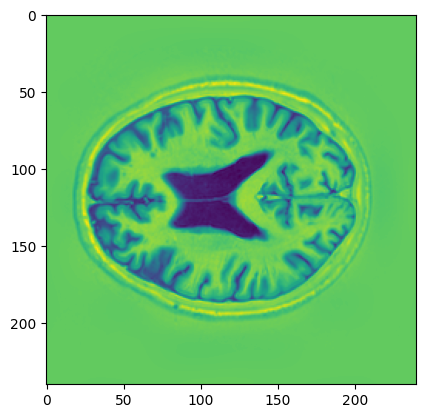

In [19]:
plt.imshow(image_data_IR[:,:,25])

### Estadarizar

In [20]:
def zscore_image(image_data):
    mean_value = image_data[image_data > 10].mean()
    standard_deviation_value = image_data[image_data > 10].std()


    image_data_rescaled = (image_data - mean_value) / (standard_deviation_value)

    return image_data_rescaled

def rescale_image(image_data):
    min_value = image_data.min()
    max_value = image_data.max()

    image_data_rescaled = (image_data - min_value) / (max_value - min_value)

    return image_data_rescaled

def white_stripe(image):
    # 1. Calcular el histograma de la imagen
    histogram = np.histogram(image, bins=256, range=(0, 255))[0]

    # 2. Dividir el histograma en tres secciones
    section_size = len(histogram) // 3
    section3 = histogram[2 * section_size:]

    peak3 = np.argmax(section3)
    ws = peak3 + 2 * section_size

    image_data_rescaled = (image / ws)

    return image_data_rescaled


### Remocion de ruido

In [21]:
def medianFilterBorders (image):
  # Median Filter with borders
	threshold = 2500
	filtered_image = np.zeros_like(image)

	for x in range(1, image.shape[0] - 2):
		for y in range(1, image.shape[1] - 2):
			for z in range(1, image.shape[2] - 2):
        # Compute the derivatives in x, y, and z directions
				dx = image[x + 1, y, z] - image[x - 1, y, z]
				dy = image[x, y + 1, z] - image[x, y - 1, z]
				dz = image[x, y, z + 1] - image[x, y, z - 1]

        # Compute the magnitude of the gradient
				magnitude = np.sqrt(dx * dx + dy * dy + dz * dz)

                    # Separate pixels based on the current threshold
				below_threshold = magnitude[magnitude < threshold]
				above_threshold = magnitude[magnitude >= threshold]
				threshold = (np.mean(below_threshold) + np.mean(above_threshold)) / 2

				if magnitude < threshold:
					neighbours = []
					for dx in range(-1, 2):
						for dy in range(-1, 2):
							for dz in range(-1, 2):
								neighbours.append(image[x + dx, y + dy, z + dz])
					median = np.median(neighbours)
					filtered_image[x, y, z] = median
				else:
					filtered_image[x, y, z] = image[x, y, z]
	return filtered_image

def median_filter(image_data):
    filtered_image = np.zeros_like(image_data)

    for x in range(1, image_data.shape[0]-1):
        for y in range(1, image_data.shape[1]-1):
            for z in range(1, image_data.shape[2]-1):
                # Extraer la vecindad 3x3x3
                neighborhood = image_data[x-1:x+2, y-1:y+2, z-1:z+2]

                new_neighborhood = np.sort(neighborhood)
                
                # Calcular la mediana de la vecindad
                median_value = np.median(new_neighborhood)
                
                # Asignar el valor mediano al píxel filtrado
                filtered_image[x, y, z] = median_value

    return filtered_image

### Segmentar

In [22]:
def kmeans_segmentation(image, k, tol, max_iter):
    # Inicializamos los centroides con valores entre el mínimo y el máximo valor de la imagen
    centroids = np.linspace(np.min(image), np.max(image), k)

    for i in range(max_iter):
        # Calculamos la distancia entre los valores de la imagen y los centroides
        distances = np.abs(image - centroids[..., None, None, None])

        # Asignamos cada pixel a su centroide más cercano
        segmentation = np.argmin(distances, axis=0)

        # Calculamos los nuevos centroides como la media de los valores asignados a cada cluster
        new_centroids = np.array([np.mean(image[segmentation == j]) for j in range(k)])

        # Comprobamos si la diferencia entre los nuevos y los antiguos centroides es menor que la tolerancia
        if np.all(np.abs(new_centroids - centroids) < tol):
            break

        # Asignamos los nuevos centroides
        centroids = new_centroids

    return segmentation

def k_means(image, ks,iteracion=10):
        
    # Inicialización de valores k
    k_values = np.linspace(np.amin(image), np.amax(image), ks)
    # iteracion=10
    for i in range(iteracion):
        d_values = [np.abs(k - image) for k in k_values]
        segmentationr = np.argmin(d_values, axis=0)

        for k_idx in range(ks):
            k_values[k_idx] = np.mean(image[segmentationr == k_idx])

    return segmentationr

### PREPROCESAR & PROCESAR

In [23]:
Estadarizada_t1 = zscore_image(image_data_T1)
Estadarizada_ir = zscore_image(image_data_IR)

Remocion_de_ruido_t1 = medianFilterBorders(Estadarizada_t1)
Remocion_de_ruido_ir = medianFilterBorders(Estadarizada_ir)


Segmentar_t1 = k_means(Remocion_de_ruido_t1, 4)
Segmentar_ir = k_means(Remocion_de_ruido_ir, 2)

In [24]:
# Obtener la información de afine de la imagen original
affine_t1 = image_T1.affine
affine_ir = image_IR.affine

# Reconstruir la imagen estandarizada con la información de afine
reconstructed_image_t1 = nib.Nifti1Image(Segmentar_t1.astype(np.float32), affine_t1)
reconstructed_image_ir = nib.Nifti1Image(Segmentar_ir.astype(np.float32), affine_ir)

# Guardar la imagen estandarizada en formato NIfTI
output_path_t1 = os.path.join("../images", "process_t1.nii.gz")
output_path_ir = os.path.join("../images", "process_ir.nii.gz")
nib.save(reconstructed_image_t1, output_path_t1)
nib.save(reconstructed_image_ir, output_path_ir)

Text(0.5, 1.0, 'IR')

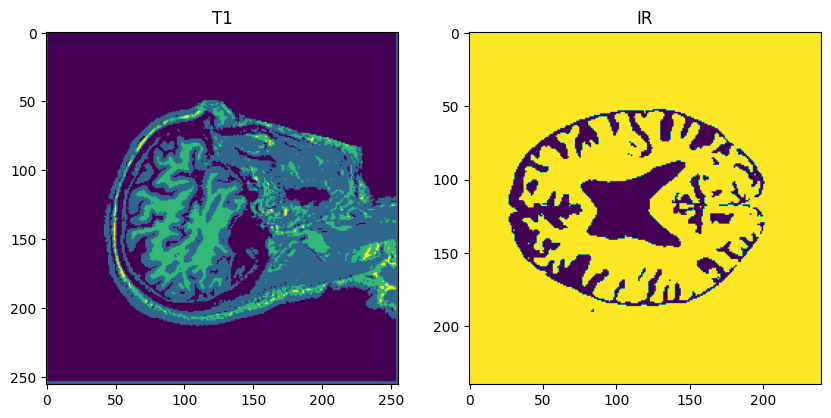

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Segmentar_t1[:, :, 50])
ax1.set_title('T1')
ax2.imshow(Segmentar_ir[:, :, 25])
ax2.set_title('IR')

### Registro

In [26]:
def registro_rigido(name, imagen_movil, imagen_referencia, imagen_seg, output_folder="../images/"):
    # Cargar las imágenes usando SimpleITK
    imagen_movil_sitk = sitk.ReadImage(imagen_movil)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia)
    imagen_seg_sitk = sitk.ReadImage(imagen_seg)

    # Convertir la imagen móvil a tipo de datos float32
    imagen_movil_sitk = sitk.Cast(imagen_movil_sitk, sitk.sitkFloat32)
    imagen_seg_sitk = sitk.Cast(imagen_seg_sitk, sitk.sitkFloat32)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia, sitk.sitkFloat32)

    # Crear el objeto de registro rígido
    registro_rigido = sitk.ImageRegistrationMethod()

    # Configurar los parámetros del registro rígido
    registro_rigido.SetMetricAsMeanSquares()
    registro_rigido.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=100)
    registro_rigido.SetInitialTransform(sitk.TranslationTransform(imagen_movil_sitk.GetDimension()))

    # Realizar el registro rígido
    transformada_resultado = registro_rigido.Execute(imagen_referencia_sitk, imagen_movil_sitk)

    # Aplicar la transformación alineada a la imagen móvil completa
    imagen_movil_registrada = sitk.Resample(imagen_seg_sitk, imagen_referencia_sitk, transformada_resultado, sitk.sitkNearestNeighbor, 0.0, sitk.sitkFloat64)

    # Obtener la matriz tridimensional de la imagen móvil registrada y reordenar las dimensiones
    matriz_registrada = sitk.GetArrayFromImage(imagen_movil_registrada)
    matriz_registrada = np.transpose(matriz_registrada, (2, 1, 0))

    # Guardar la imagen registrada en formato NIfTI
    output_path = os.path.join(output_folder, name+".nii.gz")
    image_segmented = nib.Nifti1Image(matriz_registrada, affine=np.eye(4))
    nib.save(image_segmented, output_path)
    print(f"Imagen segmentada guardada en {output_path}")

    return matriz_registrada

In [27]:
image_registro_rigido = registro_rigido("T1_reg", imagen_movil='../images/T1.nii.gz', imagen_referencia='../images/FLAIR.nii.gz', imagen_seg='../images/process_t1.nii.gz')
image_registro_rigido_IR = registro_rigido("IR_reg" , imagen_movil='../images/IR.nii.gz', imagen_referencia='../images/FLAIR.nii.gz', imagen_seg='../images/process_ir.nii.gz')

Imagen segmentada guardada en ../images/T1_reg.nii.gz
Imagen segmentada guardada en ../images/IR_reg.nii.gz


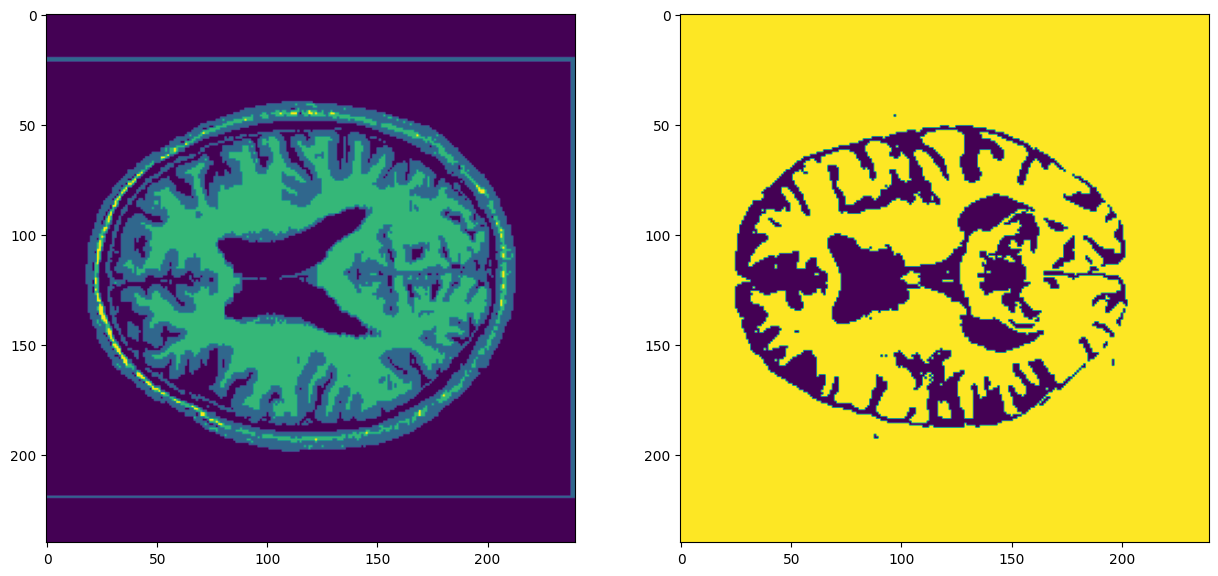

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(image_registro_rigido[:,:,25])
ax2.imshow(image_registro_rigido_IR[:,:,25])

### Remocion de craneo

In [29]:
def remove_brain(scale_mum):
    # Cargar la imagen NIfTI

    nifti_img = nib.load(
        os.path.join("../images", "IR_reg.nii.gz")
    )  # Asegúrate de ajustar la ruta y el nombre del archivo

    # Obtener los datos de la imagen
    data = nifti_img.get_fdata()

    # Definir escalas espaciales
    scales = [scale_mum]  # Escalas para aplicar filtros gaussianos

    # Aplicar filtros gaussianos en diferentes escalas
    filtered_images = []
    for scale in scales:
        # Aplicar filtro gaussiano
        filtered = ndimage.gaussian_filter(data, sigma=scale)
        filtered = k_means(filtered, 4)
        # Crear una nueva imagen nibabel con el cerebro extraído
        brain_extracted_image = nib.Nifti1Image(
            filtered, affine=nifti_img.affine, dtype=np.int16
        )

        # Guardar la imagen con el cerebro extraído en un nuevo archivo
        nib.save(brain_extracted_image, os.path.join("../images", "IR_skull.nii.gz"))
        filtered_images.append(filtered)

    # RESTAR UNA IMAGEN

    # Cargar las imágenes
    imagen_original = sitk.ReadImage(
        os.path.join("../images", "T1_reg.nii.gz")
    )
    imagen_referencia = sitk.ReadImage(os.path.join("../images/", "IR_skull.nii.gz"))

    # Modify the metadata of image2 to match image1
    imagen_referencia.SetOrigin(imagen_original.GetOrigin())
    imagen_referencia.SetSpacing(imagen_original.GetSpacing())
    imagen_referencia.SetDirection(imagen_original.GetDirection())

    # Realizar segmentación basada en umbral adaptativo
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(1)
    otsu_filter.SetOutsideValue(0)
    mascara_referencia = otsu_filter.Execute(imagen_referencia)

    # Aplicar la máscara a la imagen original
    imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

    # Obtener los datos de la imagen sin el cráneo
    # Obtener los datos de la imagen sin el cráneo
    data_sin_craneo = sitk.GetArrayFromImage(imagen_sin_craneo)

    # Obtener los datos de la máscara
    data_mascara = sitk.GetArrayFromImage(mascara_referencia)

    # Crear una máscara booleana para los valores cero dentro del cerebro
    mascara_cero_cerebro = (data_sin_craneo == 0) & (data_mascara != 0)

    # Asignar un valor distinto a los valores cero dentro del cerebro
    valor_distinto = 6
    data_sin_craneo[mascara_cero_cerebro] = valor_distinto

    # Crear una nueva imagen SimpleITK con los datos modificados
    imagen_sin_craneo_modificada = sitk.GetImageFromArray(data_sin_craneo)
    imagen_sin_craneo_modificada.CopyInformation(imagen_sin_craneo)

    # Guardar la imagen sin el cráneo

    sitk.WriteImage(
        imagen_sin_craneo_modificada, os.path.join("../images", "FLAIR_skull.nii.gz")
    )

    # ----------------------------------------------------------------------------------
    # Quitar cráneo a FLAIR Original
    # ----------------------------------------------------------------------------------
    # Cargar las imágenes

    imagen_original = sitk.ReadImage(os.path.join("../images", "FLAIR.nii.gz"))
    imagen_referencia = sitk.ReadImage(os.path.join("../images", "IR_skull.nii.gz"))

    imagen_referencia.SetOrigin(imagen_original.GetOrigin())
    imagen_referencia.SetSpacing(imagen_original.GetSpacing())
    imagen_referencia.SetDirection(imagen_original.GetDirection())


    # Realizar segmentación basada en umbral adaptativo
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(1)
    otsu_filter.SetOutsideValue(0)
    mascara_referencia = otsu_filter.Execute(imagen_referencia)

    # Aplicar la máscara a la imagen original
    imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

    # Guardar la imagen sin el cráneo

    sitk.WriteImage(
        imagen_sin_craneo,
        os.path.join("../images", "FLAIR_original_sin_craneo.nii.gz"),
    )

    # ----------------------------------------------------------------------------------
    # Segmentar lesiones
    # ----------------------------------------------------------------------------------

    image = nib.load(os.path.join("../images", "FLAIR_skull.nii.gz"))
    image_data = image.get_fdata()
    image_data_flair_without_skull = nib.load(
        os.path.join("../images", "FLAIR_original_sin_craneo.nii.gz")
    ).get_fdata()

    image_data_flair_segmented = k_means(image_data_flair_without_skull, 15, 15)

    # Where the values are 3, replace them in the image_data with a value of 3
    image_data_flair_segmented[:,:,:13] = 0
    image_data = np.where(image_data_flair_segmented == 7, 3, image_data)

    affine = image.affine
    # Create a nibabel image object from the image data
    image = nib.Nifti1Image(image_data.astype(np.float32), affine=affine)
    # Save the image as a NIfTI file
    output_path = os.path.join("../images", "FLAIR_skull_lesion.nii.gz")
    nib.save(image, output_path)

    return image_data

In [30]:
imagen_sin_craneo = remove_brain(13.5)

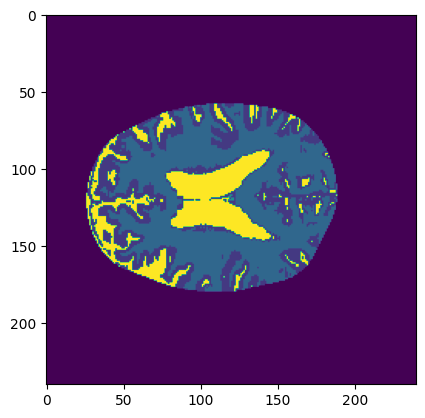

In [31]:
plt.imshow(imagen_sin_craneo[:,:,25])

In [32]:
def volumes(file_path):

    image_data_FLAIR=nib.load(file_path).get_fdata()
    result= np.where(image_data_FLAIR == 4 , 1 , 0)
    unique,counts=np.unique(image_data_FLAIR, return_counts=True)
    print(counts)
    count= np.count_nonzero(image_data_FLAIR.astype(np.int32) == 2)
    print("Cantidad de elementos iguala a 1:", count)
    return counts

In [33]:
volumess = volumes(file_path="../images/FLAIR_skull_lesion.nii.gz")
print(volumess)

[1990769  313459  230462   10762  219348]
Cantidad de elementos iguala a 1: 230462
[1990769  313459  230462   10762  219348]
